In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

/Users/anna/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data Cleaning

In [2]:
excel = pd.ExcelFile('HainanClean_New.xlsx')
hainan = excel.parse("fulldf")
hainan
hainan.columns = hainan.columns.str.replace('  ', '_')
hainan.columns = hainan.columns.str.replace(' ', '_')
hainan.columns = hainan.columns.str.replace('(', '')
hainan.columns = hainan.columns.str.replace('（', '')
hainan.columns = hainan.columns.str.replace(')', '')

d = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,
     'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
hainan.Month = hainan.Month.map(d)
hainan.BioCNG_Produced_Nm3 = hainan.BioCNG_Produced_m3.shift(-15)
hainan.drop(hainan.tail(15).index,inplace=True)
hainan = hainan[np.isfinite(hainan['Month'])]
hainan.columns
hainan = hainan[np.isfinite(hainan['Lemon_waste_t'])]
hainan = hainan[np.isfinite(hainan['Percolate_t'])]
hainan = hainan.replace(' ',0)
hainan = hainan.replace('',0)
hainan = hainan.replace('  ',0)
hainan = hainan.drop(['Year', 'Month', 'Day', 'Month_#', 'Day_#', 'Raw_Biogas_Produced_m3', 'BioCNG_Sold_m3', 'Vehicle_use_m3',
       'Liquid_Fertilizer_Produced_t', 'Solid_fertilizer_produced_t',
       'Wastewater_flow_to_WWTP_unit?', 'Solid_residues_kg','50%_NaOH/kg', 'FeCl2/kg', 'PAM/kg',
       'Defoamer/kg', 'Project_electricity_use/kWh',
       'Office_space_electricity_use/kWh', 'Water/m3', 'Diesel/L'], axis=1)
hainan.head()

,BioCNG_Produced_m3,Pig_Manure_t,Cassava_t,Fish_waste_water_t,Kitchen_food_waste_t,Municipal_fecal_residue_t,Tea_waste_t,Chicken_litter_t,Bagasse_feed_t,Alcohol_waste_t,Chinese_medicine_waste_t,Energy_grass_t,Banana_fruit_shafts_t,Lemon_waste_t,Percolate_t,Other_waste_t
0,2024.0,6.82,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,26.44
1,2909.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,28.92
2,3020.0,6.66,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,26.90
3,3042.0,12.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,2779.0,9.54,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


# Preliminary Work

In [3]:
hainan_train, hainan_test = train_test_split(hainan, test_size=0.2)
print('train data len:',len(hainan_train))
print('test data len:',len(hainan_test))

train data len: 1098
test data len: 275


In [4]:
#ols
hainan_ols = ols("BioCNG_Produced_m3 ~ Pig_Manure_t + Cassava_t + Fish_waste_water_t +\
                    Kitchen_food_waste_t + Municipal_fecal_residue_t + Tea_waste_t +\
                    Chicken_litter_t + Bagasse_feed_t + Alcohol_waste_t +\
                    Chinese_medicine_waste_t + Energy_grass_t + Banana_fruit_shafts_t +\
                    Lemon_waste_t + Percolate_t + Other_waste_t", data=hainan_train).fit()
hainan_ols_summary = hainan_ols.summary()
hainan_ols_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     BioCNG_Produced_m3   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     496.2
Date:                Fri, 13 Apr 2018   Prob (F-statistic):               0.00
Time:                        16:50:16   Log-Likelihood:                -9472.2
No. Observations:                1098   AIC:                         1.898e+04
Df Residuals:                    1082   BIC:                         1.906e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1244.7370     86.670     14.362      0.000    1074.677    1414.797
Pig_Manure_t                 54.3984      4.625     11.761      0.000      45.323      63.474
Cassava_t                    57.4162      1.743     32.948      0.000      53.997      60.835
Fish_waste_water_t           48.5951      8.098      6.001      0.000      32.706      64.484
Kitchen_food_waste_t         28.7370      4.411      6.515      0.000      20.082      37.392
Municipal_fecal_residue_t     6.5194      1.728      3.772      0.000       3.128       9.911
Tea_waste_t                   8.7541     15.015      0.583      0.560     -20.707      38.215
Chicken_litter_t             72.8786      7.115     10.243      0.000      58.919      86.839
Bagasse_feed_t               54.8163      2.899     18.907      0.000      49.127      60.505
Alcohol_waste_t              28.1718     11.895      2.368      0.018       4.833      51.511
Chinese_medicine_waste_t     91.9922     41.281      2.228      0.026      10.993     172.991
Energy_grass_t               15.2996     30.657      0.499      0.618     -44.855      75.454
Banana_fruit_shafts_t         2.7733     11.931      0.232      0.816     -20.637      26.184
Lemon_waste_t               -27.3244     36.013     -0.759      0.448     -97.987      43.338
Percolate_t                  11.4865      0.489     23.481      0.000      10.527      12.446
Other_waste_t                20.2568      4.305      4.706      0.000      11.810      28.703
==============================================================================
Omnibus:                       95.048   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              535.158
Skew:                          -0.104   Prob(JB):                    6.19e-117
Kurtosis:                       6.414   Cond. No.                         352.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the ols results based on three different dependent variable, we can see that only the first one (cumulative sum of BioCNG) has a relatively high value for R-squared. So We decided to focus on the first one.

In [5]:
# Predict on the training data
X_train = hainan_train[['Pig_Manure_t',
       'Cassava_t', 'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t']]
y_train = hainan_train.BioCNG_Produced_m3
y_pred_train = hainan_ols.predict(X_train)

# Compute the root-mean-square of training data
rms_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Training error:',rms_train/sum(y_train))

# Predict on the test data
X_test = hainan_test[['Pig_Manure_t',
       'Cassava_t', 'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t']]
y_test = hainan_test.BioCNG_Produced_m3
y_pred_test = hainan_ols.predict(X_test)

# Compute the root-mean-square of test data
rms_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Testing error:',rms_test/sum(y_test))

hainan_train.head()

Training error: 0.000229065352626
Testing error: 0.0010313264947


,BioCNG_Produced_m3,Pig_Manure_t,Cassava_t,Fish_waste_water_t,Kitchen_food_waste_t,Municipal_fecal_residue_t,Tea_waste_t,Chicken_litter_t,Bagasse_feed_t,Alcohol_waste_t,Chinese_medicine_waste_t,Energy_grass_t,Banana_fruit_shafts_t,Lemon_waste_t,Percolate_t,Other_waste_t
1029,7347.0,38.62,0.00,0.0,16.96,31.00,0.0,0.00,18.0,0.0,0.00,0.0,0.0,0.0,272.0,0.00
1051,9794.0,40.20,0.00,0.0,19.04,62.46,0.0,13.84,0.0,0.0,8.22,0.0,0.0,0.0,201.0,0.00
932,2536.0,17.22,0.00,0.0,5.92,23.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,4.84
375,7152.0,18.88,35.84,0.0,0.00,0.00,0.0,0.00,84.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00
472,1197.0,14.42,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00


# Training Algorithms

1. Logistic regression
2. SVM
3. Perceptron
4. kNN
5. Random Forest
6. xgBoost

In [6]:
#logistic regression
hainan['BioCNG_Produced_binned'] = pd.cut(hainan['BioCNG_Produced_m3'], bins=3, labels=[0, 1, 2])
hainan_train, hainan_test = train_test_split(hainan, test_size=0.2)
y_train = hainan_train.BioCNG_Produced_binned
y_test = hainan_test.BioCNG_Produced_binned
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_test)
print(confusion_matrix)

Accuracy of logistic regression classifier on train set: 0.60
Accuracy of logistic regression classifier on test set: 0.57
[[156   0   1]
 [ 59   0   0]
 [ 58   0   1]]


In [7]:
# SVM
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)  
y_pred_test = clf.predict(X_test)
print('Accuracy of SVM on train set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of SVM on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of SVM on train set: 0.86
Accuracy of SVM on test set: 0.55


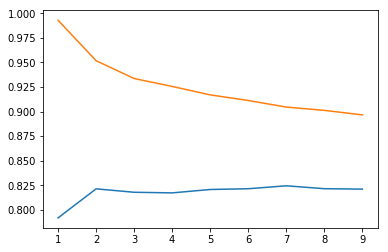

Accuracy of kNN on train set: 0.90
Accuracy of kNN on test set: 0.82


In [8]:
# kNN
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(hainan[['BioCNG_Produced_m3', 'Pig_Manure_t',
       'Cassava_t', 'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t']])
hainan_normalized = pd.DataFrame(np_scaled)
hainan_normalized_train, hainan_normalized_test = train_test_split(hainan_normalized, test_size=0.2)
hainan_normalized
Xnor_train = hainan_normalized_train.iloc[:, 1:16]    
ynor_train = hainan_normalized_train[0]
Xnor_test = hainan_normalized_test.iloc[:, 1:16]
ynor_test = hainan_normalized_test[0]
scoretest = []
scoretrain = []
for n in range(1,10):
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(Xnor_train, ynor_train)
    y_pred_test = knn.predict(Xnor_test)
    scoretest.append(knn.score(Xnor_test, ynor_test))
    scoretrain.append(knn.score(Xnor_train, ynor_train))
    #print('Accuracy of kNN on train set: {:.2f}'.format(knn.score(Xnor_train, ynor_train)))
    #print('Accuracy of kNN on test set: {:.2f}'.format(knn.score(Xnor_test, ynor_test)))
plt.plot(range(1,10), scoretest)
plt.plot(range(1,10), scoretrain)
plt.show()

knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(Xnor_train, ynor_train)
y_pred_test = knn.predict(Xnor_test)
print('Accuracy of kNN on train set: {:.2f}'.format(knn.score(Xnor_train, ynor_train)))
print('Accuracy of kNN on test set: {:.2f}'.format(knn.score(Xnor_test, ynor_test)))

In [9]:
# xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_test = xgb.predict(X_test)
print('Accuracy of XGboost on train set: {:.2f}'.format(xgb.score(X_train, y_train)))
print('Accuracy of XGboost on test set: {:.2f}'.format(xgb.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_test)
print(confusion_matrix)

Accuracy of XGboost on train set: 0.66
Accuracy of XGboost on test set: 0.54
[[146   8   3]
 [ 56   2   1]
 [ 58   1   0]]


/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
# random forest
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=1000)
random_forest.fit(X_train, y_train)
print('Accuracy of Random Forest on train set: {:.2f}'.format(random_forest.score(X_train, y_train)))
print('Accuracy of Random Forest on test set: {:.2f}'.format(random_forest.score(X_test, y_test)))

Accuracy of Random Forest on train set: 0.98
Accuracy of Random Forest on test set: 0.52


From the accuracy results of the above algorithms training, we can see that except for kNN, all of them have relatively good results for accuracy around 0.5.

# Trying with 1/x

In [11]:
print(hainan.shape)
hainan = hainan.drop(['BioCNG_Produced_binned'], axis=1)
hainan.columns

(1373, 17)


Index(['BioCNG_Produced_m3', 'Pig_Manure_t', 'Cassava_t', 'Fish_waste_water_t',
       'Kitchen_food_waste_t', 'Municipal_fecal_residue_t', 'Tea_waste_t',
       'Chicken_litter_t', 'Bagasse_feed_t', 'Alcohol_waste_t',
       'Chinese_medicine_waste_t', 'Energy_grass_t', 'Banana_fruit_shafts_t',
       'Lemon_waste_t', 'Percolate_t', 'Other_waste_t'],
      dtype='object')

In [12]:
for col in hainan.columns[1:]:
    hainan['1/'+col] = 1/(hainan[col])
hainan.head()
hainan.columns

Index(['BioCNG_Produced_m3', 'Pig_Manure_t', 'Cassava_t', 'Fish_waste_water_t',
       'Kitchen_food_waste_t', 'Municipal_fecal_residue_t', 'Tea_waste_t',
       'Chicken_litter_t', 'Bagasse_feed_t', 'Alcohol_waste_t',
       'Chinese_medicine_waste_t', 'Energy_grass_t', 'Banana_fruit_shafts_t',
       'Lemon_waste_t', 'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t',
       '1/Cassava_t', '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t'],
      dtype='object')

In [13]:
hainan.head()

,BioCNG_Produced_m3,Pig_Manure_t,Cassava_t,Fish_waste_water_t,Kitchen_food_waste_t,Municipal_fecal_residue_t,Tea_waste_t,Chicken_litter_t,Bagasse_feed_t,Alcohol_waste_t,...,1/Tea_waste_t,1/Chicken_litter_t,1/Bagasse_feed_t,1/Alcohol_waste_t,1/Chinese_medicine_waste_t,1/Energy_grass_t,1/Banana_fruit_shafts_t,1/Lemon_waste_t,1/Percolate_t,1/Other_waste_t
0,2024.0,6.82,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,inf,inf,0.066667,inf,inf,inf,inf,inf,inf,0.037821
1,2909.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,inf,inf,0.066667,inf,inf,inf,inf,inf,inf,0.034578
2,3020.0,6.66,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,inf,inf,0.066667,inf,inf,inf,inf,inf,inf,0.037175
3,3042.0,12.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
4,2779.0,9.54,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,inf,inf,0.111111,inf,inf,inf,inf,inf,inf,inf


In [14]:
#hainan.replace(float('inf'),float(0), inplace = True);
hainan.replace(float('inf'), 0, inplace=True)
hainan_train, hainan_test = train_test_split(hainan, test_size=0.2)
print('train data len:',len(hainan_train))
print('test data len:',len(hainan_test))
hainan.head()

train data len: 1098
test data len: 275


,BioCNG_Produced_m3,Pig_Manure_t,Cassava_t,Fish_waste_water_t,Kitchen_food_waste_t,Municipal_fecal_residue_t,Tea_waste_t,Chicken_litter_t,Bagasse_feed_t,Alcohol_waste_t,...,1/Tea_waste_t,1/Chicken_litter_t,1/Bagasse_feed_t,1/Alcohol_waste_t,1/Chinese_medicine_waste_t,1/Energy_grass_t,1/Banana_fruit_shafts_t,1/Lemon_waste_t,1/Percolate_t,1/Other_waste_t
0,2024.0,6.82,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.037821
1,2909.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.034578
2,3020.0,6.66,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.037175
3,3042.0,12.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,2779.0,9.54,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [15]:
hainan.columns

Index(['BioCNG_Produced_m3', 'Pig_Manure_t', 'Cassava_t', 'Fish_waste_water_t',
       'Kitchen_food_waste_t', 'Municipal_fecal_residue_t', 'Tea_waste_t',
       'Chicken_litter_t', 'Bagasse_feed_t', 'Alcohol_waste_t',
       'Chinese_medicine_waste_t', 'Energy_grass_t', 'Banana_fruit_shafts_t',
       'Lemon_waste_t', 'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t',
       '1/Cassava_t', '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t'],
      dtype='object')

In [16]:
# Predict on the training data
X_train = hainan_train[['BioCNG_Produced_m3', 'Pig_Manure_t', 'Cassava_t',
       'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t', '1/Cassava_t',
       '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t']]
y_train = hainan_train.BioCNG_Produced_m3
y_pred_train = hainan_ols.predict(X_train)

# Compute the root-mean-square of training data
rms_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Training error:',rms_train/sum(y_train))

# Predict on the test data
X_test = hainan_test[['BioCNG_Produced_m3', 'Pig_Manure_t', 'Cassava_t',
       'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t', '1/Cassava_t',
       '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t']]
y_test = hainan_test.BioCNG_Produced_m3
y_pred_test = hainan_ols.predict(X_test)

# Compute the root-mean-square of test data
rms_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Testing error:',rms_test/sum(y_test))

hainan_train.head()

Training error: 0.000237772918517
Testing error: 0.000892820161639


,BioCNG_Produced_m3,Pig_Manure_t,Cassava_t,Fish_waste_water_t,Kitchen_food_waste_t,Municipal_fecal_residue_t,Tea_waste_t,Chicken_litter_t,Bagasse_feed_t,Alcohol_waste_t,...,1/Tea_waste_t,1/Chicken_litter_t,1/Bagasse_feed_t,1/Alcohol_waste_t,1/Chinese_medicine_waste_t,1/Energy_grass_t,1/Banana_fruit_shafts_t,1/Lemon_waste_t,1/Percolate_t,1/Other_waste_t
135,2326.0,3.42,0.00,0.00,0.0,0.00,0.0,0.00,5.60,21.84,...,0.0,0.000000,0.178571,0.045788,0.0,0.0,0.0,0.000000,0.0,0.000000
1297,10958.0,41.14,0.00,10.84,96.3,95.58,0.0,32.76,0.00,0.00,...,0.0,0.030525,0.000000,0.000000,0.0,0.0,0.0,0.191571,0.0,0.000000
852,2144.0,18.54,0.00,0.00,0.0,0.00,0.0,0.00,3.00,0.00,...,0.0,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.000000,0.0,0.025253
218,3142.0,6.98,0.00,17.76,0.0,0.00,0.0,0.00,26.00,0.00,...,0.0,0.000000,0.038462,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
285,4329.0,12.10,20.28,8.28,0.0,0.00,0.0,0.00,28.37,0.00,...,0.0,0.000000,0.035249,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000


In [17]:
#logistic regression
hainan['BioCNG_Produced_binned'] = pd.cut(hainan['BioCNG_Produced_m3'], bins=3, labels=[0, 1, 2])
hainan_train, hainan_test = train_test_split(hainan, test_size=0.2)
y_train = hainan_train.BioCNG_Produced_binned
y_test = hainan_test.BioCNG_Produced_binned
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_test)
print(confusion_matrix)

Accuracy of logistic regression classifier on train set: 0.60
Accuracy of logistic regression classifier on test set: 0.59
[[160   4   1]
 [ 57   1   1]
 [ 49   2   0]]


In [18]:
# SVM
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)  
y_pred_test = clf.predict(X_test)
print('Accuracy of SVM on train set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of SVM on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of SVM on train set: 0.98
Accuracy of SVM on test set: 0.60


In [19]:
# perceptron
from sklearn.linear_model import perceptron
net = perceptron.Perceptron(n_iter=100, verbose=0, random_state=None, fit_intercept=True, eta0=0.002)
net.fit(X_train, y_train)
y_pred_test = net.predict(X_test)
print('Accuracy of perceptron on train set: {:.2f}'.format(net.score(X_train, y_train)))
print('Accuracy of perceptron on test set: {:.2f}'.format(net.score(X_test, y_test)))

Accuracy of perceptron on train set: 0.24
Accuracy of perceptron on test set: 0.21


/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


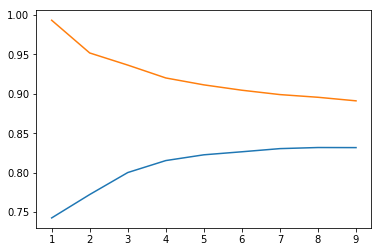

Accuracy of kNN on train set: 0.90
Accuracy of kNN on test set: 0.83


In [20]:
# kNN
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(hainan[['BioCNG_Produced_m3', 'Pig_Manure_t', 'Cassava_t',
       'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t', '1/Cassava_t',
       '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t']])
hainan_normalized = pd.DataFrame(np_scaled)
hainan_normalized_train, hainan_normalized_test = train_test_split(hainan_normalized, test_size=0.2)
hainan_normalized
Xnor_train = hainan_normalized_train.iloc[:, 1:16]    
ynor_train = hainan_normalized_train[0]
Xnor_test = hainan_normalized_test.iloc[:, 1:16]
ynor_test = hainan_normalized_test[0]
scoretest = []
scoretrain = []
for n in range(1,10):
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(Xnor_train, ynor_train)
    y_pred_test = knn.predict(Xnor_test)
    scoretest.append(knn.score(Xnor_test, ynor_test))
    scoretrain.append(knn.score(Xnor_train, ynor_train))
    #print('Accuracy of kNN on train set: {:.2f}'.format(knn.score(Xnor_train, ynor_train)))
    #print('Accuracy of kNN on test set: {:.2f}'.format(knn.score(Xnor_test, ynor_test)))
plt.plot(range(1,10), scoretest)
plt.plot(range(1,10), scoretrain)
plt.show()

knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(Xnor_train, ynor_train)
y_pred_test = knn.predict(Xnor_test)
print('Accuracy of kNN on train set: {:.2f}'.format(knn.score(Xnor_train, ynor_train)))
print('Accuracy of kNN on test set: {:.2f}'.format(knn.score(Xnor_test, ynor_test)))

In [21]:
# random forest
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators = 1000)
random_forest.fit(X_train, y_train)
print('Accuracy of Random Forest on train set: {:.2f}'.format(random_forest.score(X_train, y_train)))
print('Accuracy of Random Forest on test set: {:.2f}'.format(random_forest.score(X_test, y_test)))

Accuracy of Random Forest on train set: 0.99
Accuracy of Random Forest on test set: 0.55


# Trying with x^2

In [22]:
hainan = hainan.drop(['BioCNG_Produced_binned'], axis=1)
for col in hainan.columns[1:]:
    hainan[col+"**2"] = (hainan[col])**2
hainan.head()

,BioCNG_Produced_m3,Pig_Manure_t,Cassava_t,Fish_waste_water_t,Kitchen_food_waste_t,Municipal_fecal_residue_t,Tea_waste_t,Chicken_litter_t,Bagasse_feed_t,Alcohol_waste_t,...,1/Tea_waste_t**2,1/Chicken_litter_t**2,1/Bagasse_feed_t**2,1/Alcohol_waste_t**2,1/Chinese_medicine_waste_t**2,1/Energy_grass_t**2,1/Banana_fruit_shafts_t**2,1/Lemon_waste_t**2,1/Percolate_t**2,1/Other_waste_t**2
0,2024.0,6.82,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,0.0,0.0,0.004444,0.0,0.0,0.0,0.0,0.0,0.0,0.001430
1,2909.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,0.0,0.0,0.004444,0.0,0.0,0.0,0.0,0.0,0.0,0.001196
2,3020.0,6.66,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,0.0,0.0,0.004444,0.0,0.0,0.0,0.0,0.0,0.0,0.001382
3,3042.0,12.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,2779.0,9.54,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0.0,0.0,0.012346,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [23]:
hainan_train, hainan_test = train_test_split(hainan, test_size=0.2)
print('train data len:',len(hainan_train))
print('test data len:',len(hainan_test))
hainan.head()
hainan.columns

train data len: 1098
test data len: 275


Index(['BioCNG_Produced_m3', 'Pig_Manure_t', 'Cassava_t', 'Fish_waste_water_t',
       'Kitchen_food_waste_t', 'Municipal_fecal_residue_t', 'Tea_waste_t',
       'Chicken_litter_t', 'Bagasse_feed_t', 'Alcohol_waste_t',
       'Chinese_medicine_waste_t', 'Energy_grass_t', 'Banana_fruit_shafts_t',
       'Lemon_waste_t', 'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t',
       '1/Cassava_t', '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t', 'Pig_Manure_t**2', 'Cassava_t**2',
       'Fish_waste_water_t**2', 'Kitchen_food_waste_t**2',
       'Municipal_fecal_residue_t**2', 'Tea_waste_t**2', 'Chicken_litter_t**2',
       'Bagasse_feed_t**2', 'Alcohol_waste_t**2',
       'Chinese_medicine_waste_t**2', 'Energy_grass_t**2',
   

In [25]:
# Predict on the training data
X_train = hainan_train[['Pig_Manure_t', 'Cassava_t', 'Fish_waste_water_t',
       'Kitchen_food_waste_t', 'Municipal_fecal_residue_t', 'Tea_waste_t',
       'Chicken_litter_t', 'Bagasse_feed_t', 'Alcohol_waste_t',
       'Chinese_medicine_waste_t', 'Energy_grass_t', 'Banana_fruit_shafts_t',
       'Lemon_waste_t', 'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t',
       '1/Cassava_t', '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t', 'Pig_Manure_t**2', 'Cassava_t**2',
       'Fish_waste_water_t**2', 'Kitchen_food_waste_t**2',
       'Municipal_fecal_residue_t**2', 'Tea_waste_t**2', 'Chicken_litter_t**2',
       'Bagasse_feed_t**2', 'Alcohol_waste_t**2',
       'Chinese_medicine_waste_t**2', 'Energy_grass_t**2',
       'Banana_fruit_shafts_t**2', 'Lemon_waste_t**2', 'Percolate_t**2',
       'Other_waste_t**2', '1/Pig_Manure_t**2', '1/Cassava_t**2',
       '1/Fish_waste_water_t**2', '1/Kitchen_food_waste_t**2',
       '1/Municipal_fecal_residue_t**2', '1/Tea_waste_t**2',
       '1/Chicken_litter_t**2', '1/Bagasse_feed_t**2', '1/Alcohol_waste_t**2',
       '1/Chinese_medicine_waste_t**2', '1/Energy_grass_t**2',
       '1/Banana_fruit_shafts_t**2', '1/Lemon_waste_t**2', '1/Percolate_t**2',
       '1/Other_waste_t**2']]
y_train = hainan_train.BioCNG_Produced_m3
y_pred_train = hainan_ols.predict(X_train)

# Predict on the test data
X_test = hainan_test[['Pig_Manure_t', 'Cassava_t', 'Fish_waste_water_t',
       'Kitchen_food_waste_t', 'Municipal_fecal_residue_t', 'Tea_waste_t',
       'Chicken_litter_t', 'Bagasse_feed_t', 'Alcohol_waste_t',
       'Chinese_medicine_waste_t', 'Energy_grass_t', 'Banana_fruit_shafts_t',
       'Lemon_waste_t', 'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t',
       '1/Cassava_t', '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t', 'Pig_Manure_t**2', 'Cassava_t**2',
       'Fish_waste_water_t**2', 'Kitchen_food_waste_t**2',
       'Municipal_fecal_residue_t**2', 'Tea_waste_t**2', 'Chicken_litter_t**2',
       'Bagasse_feed_t**2', 'Alcohol_waste_t**2',
       'Chinese_medicine_waste_t**2', 'Energy_grass_t**2',
       'Banana_fruit_shafts_t**2', 'Lemon_waste_t**2', 'Percolate_t**2',
       'Other_waste_t**2', '1/Pig_Manure_t**2', '1/Cassava_t**2',
       '1/Fish_waste_water_t**2', '1/Kitchen_food_waste_t**2',
       '1/Municipal_fecal_residue_t**2', '1/Tea_waste_t**2',
       '1/Chicken_litter_t**2', '1/Bagasse_feed_t**2', '1/Alcohol_waste_t**2',
       '1/Chinese_medicine_waste_t**2', '1/Energy_grass_t**2',
       '1/Banana_fruit_shafts_t**2', '1/Lemon_waste_t**2', '1/Percolate_t**2',
       '1/Other_waste_t**2']]
y_test = hainan_test.BioCNG_Produced_m3
y_pred_test = hainan_ols.predict(X_test)


In [26]:
#logistic regression
hainan['BioCNG_Produced_binned'] = pd.cut(hainan['BioCNG_Produced_m3'], bins=3, labels=[0, 1, 2])
hainan_train, hainan_test = train_test_split(hainan, test_size=0.2)
y_train = hainan_train.BioCNG_Produced_binned
y_test = hainan_test.BioCNG_Produced_binned
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_test)
print(confusion_matrix)

Accuracy of logistic regression classifier on train set: 0.58
Accuracy of logistic regression classifier on test set: 0.60
[[166   2   7]
 [ 57   0   0]
 [ 43   0   0]]


In [27]:
# SVM
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)  
y_pred_test = clf.predict(X_test)
print('Accuracy of SVM on train set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of SVM on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of SVM on train set: 0.94
Accuracy of SVM on test set: 0.63


In [28]:
# perceptron
from sklearn.linear_model import perceptron
net = perceptron.Perceptron(n_iter=100, verbose=0, random_state=None, fit_intercept=True, eta0=0.002)
net.fit(X_train, y_train)
y_pred_test = net.predict(X_test)
print('Accuracy of perceptron on train set: {:.2f}'.format(net.score(X_train, y_train)))
print('Accuracy of perceptron on test set: {:.2f}'.format(net.score(X_test, y_test)))

Accuracy of perceptron on train set: 0.53
Accuracy of perceptron on test set: 0.56


/Users/anna/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [ ]:
#knn
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred_test = knn.predict(X_test)
scoretest = []
scoretrain = []
for n in range(1,10):
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred_test = knn.predict(X_test)
    scoretest.append(knn.score(X_test, y_test))
    scoretrain.append(knn.score(X_train, y_train))
plt.plot(range(1,10), scoretest)
plt.plot(range(1,10), scoretrain)
plt.show()
scoretest
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train, y_train)
y_pred_test = knn.predict(X_test)
print('Accuracy of kNN on train set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy of kNN on test set: {:.2f}'.format(knn.score(X_test, y_test)))
y_pred_test

In [35]:
# random forest
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators = 1000)
random_forest.fit(X_train, y_train)
print('Accuracy of Random Forest on train set: {:.2f}'.format(random_forest.score(X_train, y_train)))
print('Accuracy of Random Forest on test set: {:.2f}'.format(random_forest.score(X_test, y_test)))

Accuracy of Random Forest on train set: 0.97
Accuracy of Random Forest on test set: 0.53
